<a href="https://colab.research.google.com/github/IpastorSan/GAN_neural_style_transfer/blob/black_white_content_avg_pooling/style_transfer_branch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First try to implement style transfer based on "A neural Algorithm of Artistic Style" https://arxiv.org/pdf/1508.06576.pdf

In [519]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg19
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Image, display

In [520]:
content_image_path = "temple_of_heaven_content.jpg"
style_image_path = "dali_style.jpg"
result_prefix = "temple_gen"

In [521]:
#Weights of the different weight components (leap of faith)
total_variation_weight = 1e4
style_weight = 1e-3
content_weight = 1e4

In [522]:
#Dimensions of generated picture
#Generated picture: random image that will be optimized with respect to content and style image
width, height = tf.keras.preprocessing.image.load_img(content_image_path).size
img_nrows = 512
img_ncols = int(width*img_nrows / height)

In [523]:
def load_img_as_numpy(image):
    img = tf.keras.preprocessing.image.load_img(image)
    img = tf.keras.preprocessing.image.img_to_array(img)
    return img

In [524]:
def show_img(image, title=None):
    if len(image.shape) > 3:
        tf.squeeze(image, axis = 0)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.imshow(image/255)

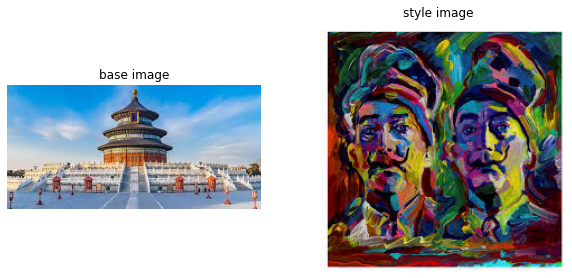

In [525]:
content = load_img_as_numpy(content_image_path)
style = load_img_as_numpy(style_image_path)

fig, ax = plt.subplots(figsize=(10, 10))

plt.subplot(1, 2, 1)
show_img(content, "base image")

plt.subplot(1, 2, 2)
show_img(style, "style image")

#1) Preprocessing

In [526]:
def preprocess_image(image_path, image_type="content"):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    #The images are converted from RGB to BGR,\
    # then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
    img = vgg19.preprocess_input(img)
    #We turn the content image into grayscale, preserving the 3 channels that VGG19 expects
    #This helps transfering colour from the style image
    if image_type == "content":
        gray_value = tf.constant([0.2989, 0.5870, 0.1140])
        img = np.dot(img[...,:3], gray_value, )
        img = np.expand_dims(img, axis=3)
        img = np.repeat(img, axis=3, repeats=3)
       
    return tf.convert_to_tensor(img)

In [527]:
content_processed = preprocess_image(content_image_path)
style_processed = preprocess_image(style_image_path, image_type="None")

In [528]:
print(f"Content processed shape : {content_processed.shape}\nStyle processed shape {style_processed.shape}")

Content processed shape : (1, 512, 1043, 3)
Style processed shape (1, 512, 1043, 3)


In [529]:
def unprocess_image(img):
    #Transforms a tensor into a valid image
    img = tf.reshape(img,(img_nrows, img_ncols, 3))
    img = img.numpy()
    #remove zero-center by mean pixel
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

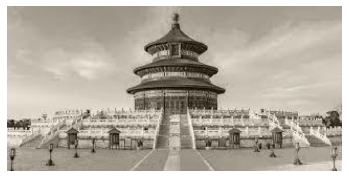

In [530]:
c = preprocess_image(content_image_path)
c = unprocess_image(c)
show_img(tf.squeeze(c))

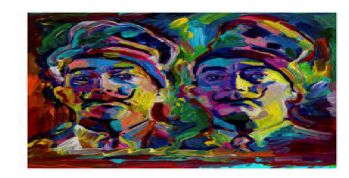

In [531]:
s = preprocess_image(style_image_path, image_type="as")
s = unprocess_image(s)
show_img(tf.squeeze(s))

#2) Loss functions

We need a picture here, following the shape transformations of the gram matrix

In [532]:
def gram_matrix(x):
    #input is (1, Height, Width, C) ---> (H,W,C)
    x = tf.squeeze(x)
    x = tf.transpose(x, (2,0,1))   #shape (C,H,W)
    
    features = tf.reshape(x, (tf.shape(x)[0], -1))  #shape (C, H*W)
    
    gram = tf.matmul(features, tf.transpose(features)) #dot product of features and transposed of features (autocorrelation)
    
    return gram/len(features[1])

In [533]:
def style_loss(style, combination):
    s = gram_matrix(style)
    c = gram_matrix(combination)
    channels = 3 
    size = 224 #size of largest feature map in VGG19
    return tf.reduce_sum(tf.square(s-c)) #/ (4.0 * (channels ** 2) * (size**2)) #Original formula from the paper

In [534]:
def content_loss(content, combination):
    return tf.reduce_sum(tf.square(content - combination))

In [535]:
def total_loss(x):
    #this loss is intended to act as a regularization of high frequency vertical and horizontal artifacts of an image
    a = tf.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.01))

#This formula is more explicit, but Tensorflow 2.0 has a direct implementation
#def total_loss(x):
#    x = tf.image.total_variation(x)   
#    return x

#2) Model

In [536]:
#Model with pre-trained Imagenet weights
model = vgg19.VGG19(weights="imagenet", include_top=False, pooling="avg")
model.trainable=False

#Dictionary to get the output of each "key" layer
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

#Model that returns the activation of every layer in VGGG19 (as a dictionary)
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=outputs_dict)
feature_extractor.trainable = False

In [537]:
#List of layers to use in the style loss (5, as per the paper)
style_layer_names = ["block1_conv1", "block2_conv1", "block3_conv1",\
                     "block4_conv1", "block5_conv1"]

#Layer to use for the content loss
content_layer_name = "block5_conv2"

def compute_loss(combination_image, content_image, style_image):
    input_tensor = tf.concat([content_image, style_image, combination_image], axis=0)
    #content_image = axis 0 index 0, style_image = axis 0 index 1, combination_image = axis 0 index 2, 
    features = feature_extractor(inputs=input_tensor)
    
    #Initialize loss
    loss = tf.zeros(shape=())
    
    #Add content loss
    layer_features = features[content_layer_name] #extract layer by name
    content_image_features = layer_features[0, :, :, :] #gets all the weights up to block5_conv2, passed by the input of content image
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(content_image_features, combination_features)

    #add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl
    
    #add total variation loss
    loss += total_variation_weight * total_loss(combination_image)
    
    return loss


#3) Loss and gradient computation

In [538]:
@tf.function
def compute_loss_and_gradients(combination_image, content_image, style_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, content_image, style_image)
    gradients = tape.gradient(loss, combination_image)
    return loss, gradients

#4)Training Loop

In [539]:
optimizer = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

content_image = preprocess_image(content_image_path)

style_image = preprocess_image(style_image_path, image_type="style")

combination_image = np.random.random((img_nrows, img_ncols)) #look into generating a random image
combination_image = np.expand_dims(combination_image, axis = 2)
combination_image = np.repeat(combination_image, repeats = 3, axis=2)
combination_image = combination_image.astype("float32")
combination_image = np.expand_dims(combination_image, axis = 0)
combination_image = tf.Variable(combination_image)


iterations = 4000
for i in range(1, iterations + 1):
    loss, gradients = compute_loss_and_gradients(combination_image, content_image, style_image)
    optimizer.apply_gradients([(gradients, combination_image)]) #investigar
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss}")
        img = unprocess_image(combination_image.numpy())
        fname = result_prefix +"_at_iteration_"+str(i)+".png"
        tf.keras.preprocessing.image.save_img(fname, img)

Iteration 100: loss=7874437709824.0
Iteration 200: loss=5322325360640.0
Iteration 300: loss=4228589813760.0
Iteration 400: loss=3659193122816.0
Iteration 500: loss=3342904852480.0
Iteration 600: loss=3143249166336.0
Iteration 700: loss=3010045411328.0
Iteration 800: loss=2909467574272.0
Iteration 900: loss=2820014080000.0
Iteration 1000: loss=2744972214272.0
Iteration 1100: loss=2692835180544.0
Iteration 1200: loss=2650892926976.0
Iteration 1300: loss=2616410505216.0
Iteration 1400: loss=2582581870592.0
Iteration 1500: loss=2552713707520.0
Iteration 1600: loss=2521127714816.0
Iteration 1700: loss=2485006630912.0
Iteration 1800: loss=2456782110720.0
Iteration 1900: loss=2429947740160.0
Iteration 2000: loss=2410335436800.0
Iteration 2100: loss=2396192505856.0
Iteration 2200: loss=2383317827584.0
Iteration 2300: loss=2372983586816.0
Iteration 2400: loss=2363587821568.0
Iteration 2500: loss=2354349604864.0
Iteration 2600: loss=2346816372736.0
Iteration 2700: loss=2339390881792.0
Iteration 

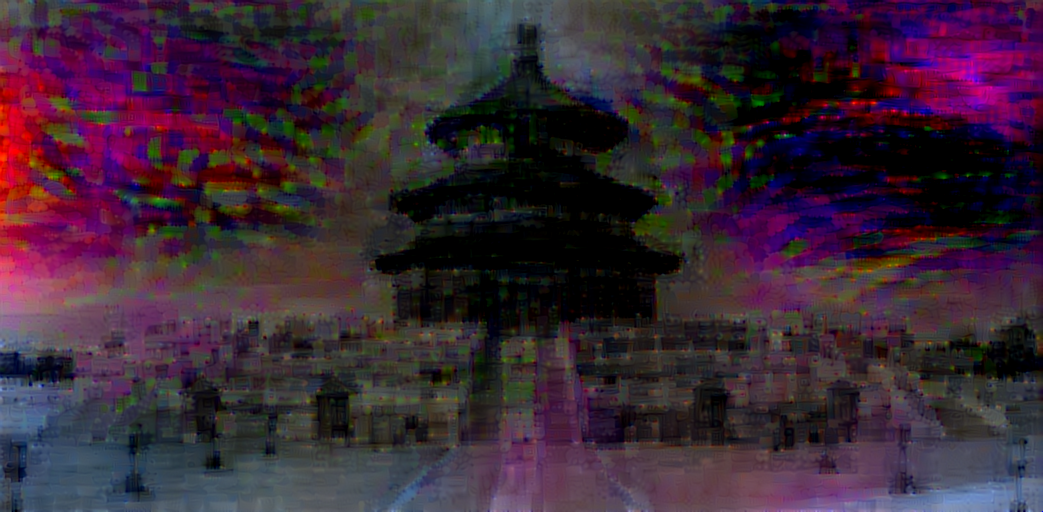

In [540]:
display(Image(fname))